### 1) 데이터 준비와 확인

In [1]:
import os
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as img
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from sklearn.model_selection import train_test_split
!pip install python-Levenshtein
#!pip install --upgrade gensim==3.8.3
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
from konlpy.tag import Mecab
from tensorflow.keras.initializers import Constant
from tensorflow.keras import layers

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

In [2]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
num_words=25000

def load_data(train_data, test_data, num_words):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
      
X_train, Y_train, x_test, y_test, word_to_index = load_data(train_data, test_data, num_words) 

In [3]:
word_to_index['<PAD>']=0
word_to_index['<BOS>']=1
word_to_index['<UNK>']=2
word_to_index["<UNUSED>"] = 3

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 3) 모델구성을 위한 데이터 분석 및 가공

In [6]:
total_data_text = list(X_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

### 4) 모델구성 및 validation set 구성

In [8]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1)

vocab_size = num_words  # 어휘 사전의 크기입니다
word_vector_dim = 200  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다.

In [9]:
rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
rnn_model.add(keras.layers.Dense(8, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         5000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 5,006,769
Trainable params: 5,006,769
Non-trainable params: 0
_________________________________________________________________


In [10]:
cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(8, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         5000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [11]:
max_model = keras.Sequential()
max_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
max_model.add(keras.layers.GlobalMaxPooling1D())
max_model.add(keras.layers.Dense(8, activation='relu'))
max_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

max_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         5000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 5,001,617
Trainable params: 5,001,617
Non-trainable params: 0
_________________________________________________________________


In [12]:
mix_model = keras.Sequential()
mix_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
mix_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
mix_model.add(keras.layers.MaxPooling1D(5))
mix_model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
mix_model.add(keras.layers.Dense(8, activation='relu'))
mix_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

mix_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         5000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 5,023,297
Trainable params: 5,023,297
Non-trainable params: 0
____________________________________________

In [13]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
embed_dim = 200  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

In [14]:
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)

trans_model = keras.Sequential()
trans_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
trans_model.add(transformer_block)
trans_model.add(keras.layers.GlobalMaxPooling1D())
trans_model.add(keras.layers.Dense(8, activation='relu'))
trans_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

trans_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         5000000   
_________________________________________________________________
transformer_block (Transform (None, None, 200)         335232    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 5,336,849
Trainable params: 5,336,849
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [15]:
epochs = 2
num=0
model_list=['rnn_model', 'cnn_model', 'max_model', 'mix_model', 'trans_model']
hist_dic={}
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    
    print(model_list[num])
    
    i.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = i.fit(x_train, y_train, epochs=epochs, batch_size=512, validation_data=(x_val, y_val),
                    verbose=1)
    hist_dic[model_list[num]]=history
    num+=1

rnn_model
Epoch 1/2
200/200 [==============================] - 14s 57ms/step - loss: 0.5574 - accuracy: 0.7198 - val_loss: 0.3636 - val_accuracy: 0.8441
Epoch 2/2
200/200 [==============================] - 10s 51ms/step - loss: 0.3066 - accuracy: 0.8756 - val_loss: 0.3510 - val_accuracy: 0.8494
cnn_model
Epoch 1/2
200/200 [==============================] - 20s 78ms/step - loss: 0.5686 - accuracy: 0.6840 - val_loss: 0.3517 - val_accuracy: 0.8505
Epoch 2/2
200/200 [==============================] - 10s 51ms/step - loss: 0.2830 - accuracy: 0.8854 - val_loss: 0.3399 - val_accuracy: 0.8552
max_model
Epoch 1/2
200/200 [==============================] - 10s 49ms/step - loss: 0.6181 - accuracy: 0.6832 - val_loss: 0.3668 - val_accuracy: 0.8411
Epoch 2/2
200/200 [==============================] - 10s 48ms/step - loss: 0.3182 - accuracy: 0.8678 - val_loss: 0.3433 - val_accuracy: 0.8541
mix_model
Epoch 1/2
200/200 [==============================] - 13s 56ms/step - loss: 0.5676 - accuracy: 0.7090 -

In [16]:
num=0
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    print(model_list[num])
    results = i.evaluate(x_test,  y_test, verbose=2)
    print('')
    num+=1

rnn_model
1537/1537 - 5s - loss: 0.3552 - accuracy: 0.8463

cnn_model
1537/1537 - 6s - loss: 0.3441 - accuracy: 0.8528

max_model
1537/1537 - 3s - loss: 0.3454 - accuracy: 0.8502

mix_model
1537/1537 - 4s - loss: 0.3424 - accuracy: 0.8527

trans_model
1537/1537 - 6s - loss: 0.3547 - accuracy: 0.8474



GlobalMaxPooling1D만 사용한 모델도 준수한 성능을 보인다.

### 6) Loss, Accuracy 그래프 시각화

In [17]:
num=0
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    history_dict = hist_dic[model_list[num]].history
    print(model_list[num],history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
    num+=1

rnn_model dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
cnn_model dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
max_model dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
mix_model dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
trans_model dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


rnn_model


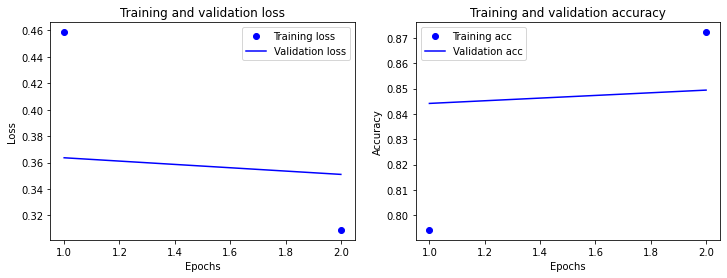

cnn_model


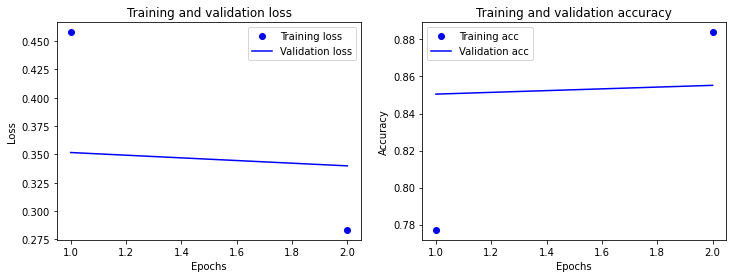

max_model


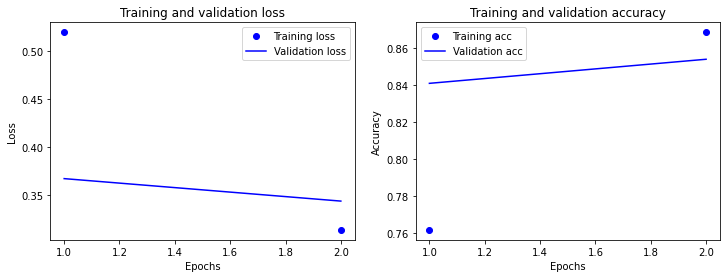

mix_model


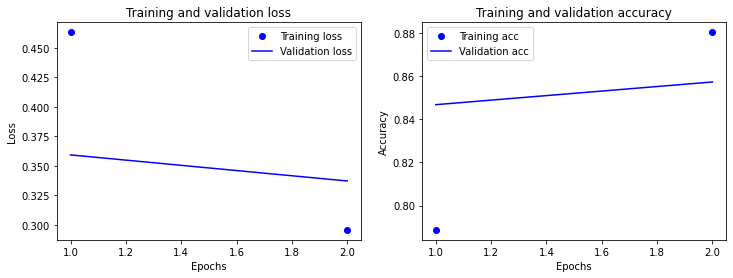

trans_model


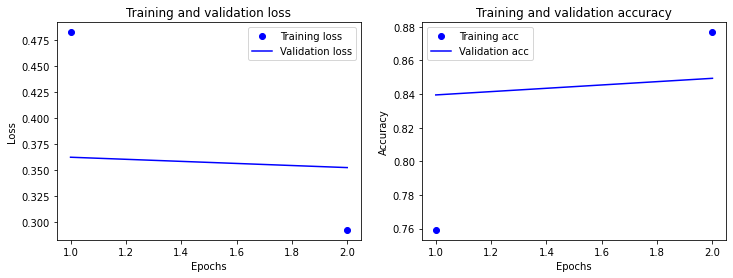

In [18]:
num=0
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    history_dict = hist_dic[model_list[num]].history
    
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    print(model_list[num])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    num+=1

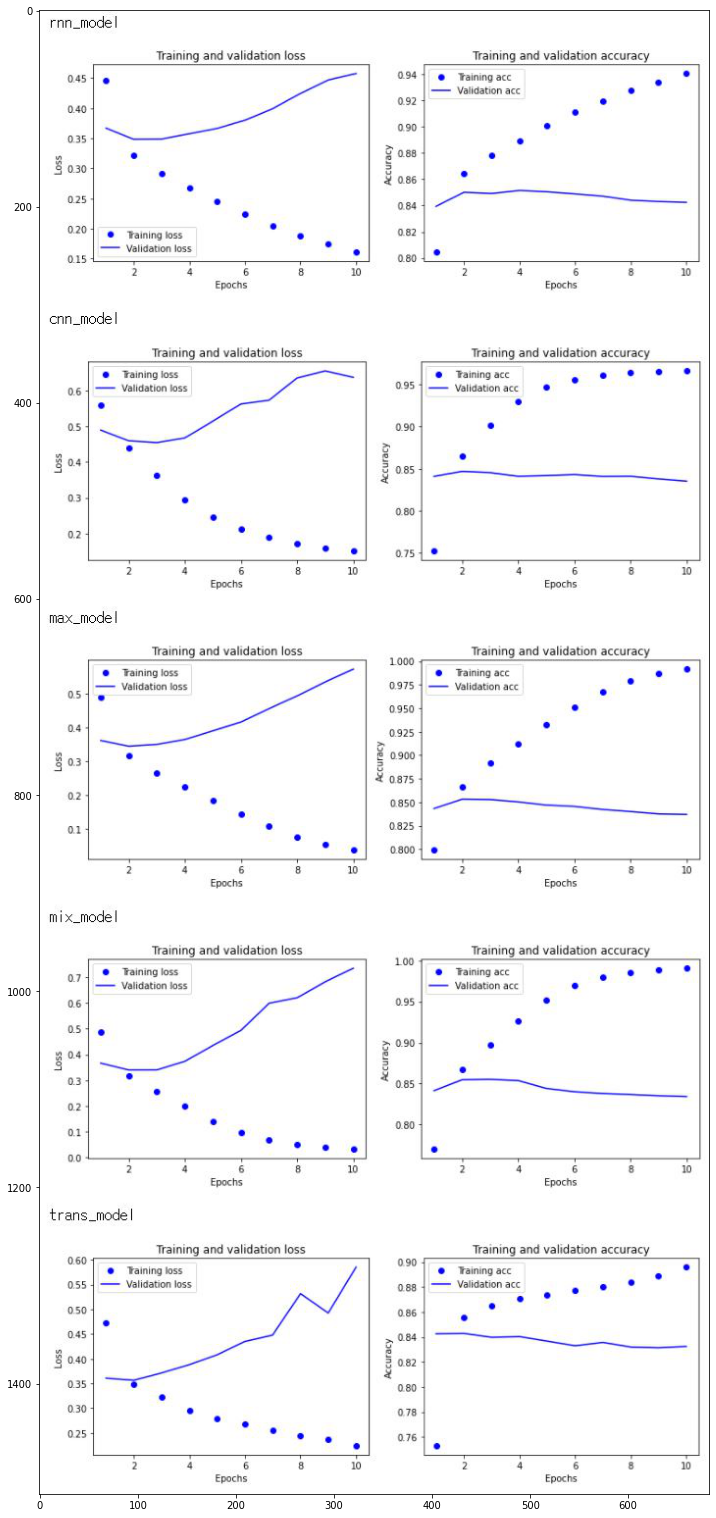

In [19]:
file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/epoch10.JPG'
image = img.imread(file_path)
plt.figure(figsize=(12,60))
plt.imshow(image)
plt.show()

epochs = 10 으로 학습을 했을 때 loss와 accuracy를 그래프로 확인해 epoch = 2 이후 과적합이 발생하는 것을 보았다.
그래프 확인 후 epoch = 2로 다시 학습을 진행하였다.

### 7) 학습된 Embedding 레이어 분석

In [20]:
num=0
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    print(model_list[num])
    embedding_layer = i.layers[0]
    weights = embedding_layer.get_weights()[0]
    print(weights.shape)
    
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/{}_word2vec.txt'.format(model_list[num])
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

    # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
    vectors = i.get_weights()[0]
    for i in range(4,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    vector = word_vectors['컴퓨터']
    print(vector)
    
    print('')
    a = word_vectors.similar_by_word("사랑")
    for i in a:
        print(i)
    print('\n')
    num+=1

rnn_model
(25000, 200)
[-1.40486751e-02 -5.57776466e-02  5.82334585e-02 -3.28063928e-02
 -8.37591197e-03 -4.86509549e-03  1.38104404e-03 -2.57341075e-03
 -4.95786928e-02 -4.48053405e-02 -1.71546023e-02  7.55812507e-03
 -2.15325821e-02  4.29605879e-02 -3.99852097e-02  6.49871528e-02
  4.95283939e-02 -3.19561735e-02 -2.71525253e-02  5.51861115e-02
  2.71736588e-02  1.00894347e-02 -3.52313300e-03  3.58748510e-02
 -1.13874543e-02 -1.40603669e-02 -1.99802704e-02  3.69878951e-03
 -7.23896222e-03 -1.17729651e-02  1.80472303e-02 -2.02654954e-02
  1.25411889e-02  1.96247399e-02  8.78045335e-03 -1.61413802e-03
 -1.66869443e-02  1.06467735e-02  4.27760296e-02 -9.27988440e-03
 -2.70801336e-02 -1.78101994e-02  3.20515558e-02 -6.55767247e-02
  2.64631491e-02 -3.24259815e-03  2.42053401e-02 -2.38625146e-02
 -1.91781595e-02  2.37398525e-03  4.11158055e-02  1.02705816e-02
 -4.55674641e-02 -2.64373794e-02 -3.22685763e-02  4.06869873e-02
 -1.03711206e-02  1.96224917e-02  2.92916633e-02  1.37929246e-02
  

In [21]:
num=0
for i in [rnn_model, cnn_model, max_model, mix_model, trans_model]:
    print(model_list[num])

    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/{}_word2vec.txt'.format(model_list[num])
    
    
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    al=['우정', '밥', '종이', '밤']
    for j in al:
        a = word_vectors.similar_by_word(j)
        for i in a:
            print(i)
        print('\n')
    print('\n')
    num+=1

rnn_model
('갑', 0.5287853479385376)
('훌륭', 0.5261017680168152)
('담겨져', 0.5195759534835815)
('쩔', 0.5186587572097778)
('싯', 0.517877459526062)
('지연', 0.5172591209411621)
('웃겨요', 0.5159599781036377)
('쏙', 0.5134472846984863)
('케미', 0.5133026838302612)
('올려', 0.5131710171699524)


('촌스럽', 0.2971702814102173)
('침울', 0.2840438783168793)
('딸아이', 0.28147828578948975)
('꿔', 0.27806514501571655)
('퀘이드', 0.2747526466846466)
('어느덧', 0.27202799916267395)
('.,,.', 0.26737573742866516)
('가져다가', 0.2646985948085785)
('소룡', 0.262386679649353)
('얀센', 0.260223388671875)


('왜곡', 0.5807535648345947)
('컨디션', 0.580336332321167)
('왕정', 0.5784000754356384)
('눈살', 0.5736446976661682)
('강요', 0.5716050863265991)
('죄송', 0.5714949369430542)
('표절', 0.5710873603820801)
('우익', 0.5699809789657593)
('할래', 0.5695497393608093)
('결여', 0.5687973499298096)


('만점', 0.6672381162643433)
('개꿀', 0.6587231159210205)
('펑펑', 0.6506457328796387)
('완벽', 0.6490422487258911)
('뭉클', 0.6482082605361938)
('나무랄', 0.6480260491371155)
('훈훈'

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [22]:
!pip list | grep gensim
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec =gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['컴퓨터']
vector

gensim                        3.8.3
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


array([-1.517628  , -0.8935504 , -1.4352998 ,  1.5069847 , -1.5178334 ,
        1.1542678 , -2.94064   ,  1.1850045 ,  0.19959009, -1.5288961 ,
       -1.7067502 , -2.1892095 , -0.20728938, -2.2606812 , -2.2283888 ,
        0.32318738, -0.2845471 , -0.07731772, -0.86269003, -1.1722927 ,
       -0.91062415,  0.8440715 ,  0.903278  , -0.84685427,  0.7023384 ,
       -2.1920419 , -0.47571626, -0.60159504, -0.68860835,  0.18944737,
        0.5319404 ,  0.73058116, -0.9658133 , -1.0123725 , -0.36183038,
        2.5851305 ,  0.66589296, -1.7231252 ,  1.7576753 ,  0.88845277,
        1.5791365 , -4.430691  ,  0.36731872,  0.69481534, -0.46041563,
        1.742655  , -1.5077016 ,  0.72209424, -0.04532204, -0.6557301 ,
       -0.71276623,  0.26522732, -0.17656395, -2.4720876 , -0.845565  ,
        0.23591152,  1.3414925 ,  0.77577615, -2.289371  , -0.8078124 ,
        1.4359473 ,  0.22882733, -1.08867   ,  1.2607764 , -1.7469797 ,
        0.06542054,  0.39896825, -0.3160832 , -1.7257563 ,  0.54

In [23]:
word2vec.similar_by_word("사랑")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [24]:
word2vec.similar_by_word("우정")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('상생', 0.48902615904808044),
 ('만남', 0.44860395789146423),
 ('결연', 0.44589829444885254),
 ('나눔', 0.4433784484863281),
 ('교분', 0.4403676390647888),
 ('사랑과', 0.4367825388908386),
 ('동반자', 0.42849019169807434),
 ('젊음', 0.4250190854072571),
 ('친분', 0.42466238141059875),
 ('애정', 0.42464712262153625)]

In [25]:
word2vec.similar_by_word("밥")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('스폰지', 0.6359171867370605),
 ('반찬', 0.6288836002349854),
 ('떡', 0.6208181381225586),
 ('계란', 0.6053064465522766),
 ('시럽', 0.6036492586135864),
 ('초콜릿', 0.6027452349662781),
 ('푸딩', 0.5942443609237671),
 ('국물', 0.5894560813903809),
 ('치킨', 0.589329719543457),
 ('비스킷', 0.5666051506996155)]

In [26]:
word2vec.similar_by_word("종이")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('연필', 0.5506081581115723),
 ('항아리', 0.543587327003479),
 ('잉크', 0.5431183576583862),
 ('종', 0.5342435240745544),
 ('활자', 0.5299221277236938),
 ('여종', 0.5147579908370972),
 ('물감', 0.5109112858772278),
 ('칠기', 0.510757565498352),
 ('대나무', 0.49649709463119507),
 ('목판', 0.4939662218093872)]

In [27]:
word2vec.similar_by_word("밤")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('저녁', 0.7863157391548157),
 ('아침', 0.7393144965171814),
 ('새벽', 0.6592653393745422),
 ('그날', 0.6430056095123291),
 ('섣달', 0.601357638835907),
 ('첫날', 0.5822462439537048),
 ('주말', 0.5778944492340088),
 ('금요일', 0.5603185296058655),
 ('토요일', 0.5600857734680176),
 ('정오', 0.5574322938919067)]

학습된 word2vec을 이용했을 때 직접 모델을 통해 학습한 word2vec보다 유사한 단어목록이 훨씬 좋은 결과를 볼 수 있었다.

In [28]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [29]:
# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           5000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [30]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 4

history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/4
200/200 [==============================] - 11s 53ms/step - loss: 0.6195 - accuracy: 0.6302 - val_loss: 0.4549 - val_accuracy: 0.7850
Epoch 2/4
200/200 [==============================] - 10s 52ms/step - loss: 0.4087 - accuracy: 0.8164 - val_loss: 0.3927 - val_accuracy: 0.8246
Epoch 3/4
200/200 [==============================] - 10s 51ms/step - loss: 0.3224 - accuracy: 0.8636 - val_loss: 0.3771 - val_accuracy: 0.8362
Epoch 4/4
200/200 [==============================] - 10s 51ms/step - loss: 0.2700 - accuracy: 0.8890 - val_loss: 0.3898 - val_accuracy: 0.8342


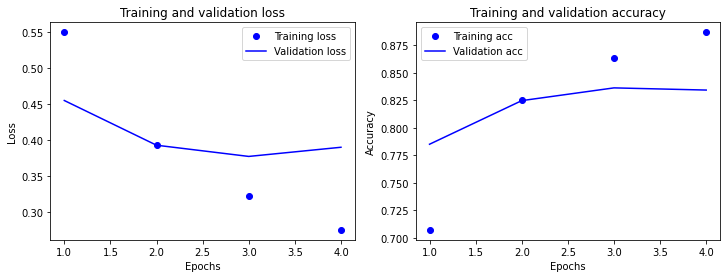

In [31]:
history_dict = history.history
    
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3915 - accuracy: 0.8326
[0.39146530628204346, 0.8325976133346558]


사전 학습된 word2vec은 보기에 더 좋지만 주어진 데이터를 정확하게 판단하는데 있어서는 성능이 저하되었다.
영화리뷰 텍스트 데이터로 직접 학습시킨 word2vec이 영화리뷰 텍스트 예측에 더 적합한것 같다.

직접 학습시킨 모델
rnn_model
1537/1537 - 5s - loss: 0.3552 - accuracy: 0.8463

cnn_model
1537/1537 - 6s - loss: 0.3441 - accuracy: 0.8528

max_model
1537/1537 - 3s - loss: 0.3454 - accuracy: 0.8502

mix_model
1537/1537 - 4s - loss: 0.3424 - accuracy: 0.8527

trans_model
1537/1537 - 6s - loss: 0.3547 - accuracy: 0.8474

사전 학습된 word2vec 이용한 cnn_model
1537/1537 - 3s - loss: 0.3915 - accuracy: 0.8326